In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.constants import c as clight
from astropy.constants import e as e_elec
from astropy.constants import h as hplanck
from astropy.cosmology import WMAP9 as cosmo

plt.rcParams["text.usetex"]=True
plt.rcParams["axes.labelsize"]=20
plt.rcParams["xtick.labelsize"]=20
plt.rcParams["ytick.labelsize"]=20
plt.rcParams["legend.fontsize"]=20

In [2]:
zqso=5.887
Hz=cosmo.H(zqso).value
H0=cosmo.H(0).value

In [3]:
Req=18 #pMpc
xi=0.67
kapbg=10**(-24.5) #cm^-2 wrong, cm^-1

In [4]:
def kap(drArr,Req,xi,kapbg):
    """
    Calculate kappa profile given inputs.

    Parameters:
    - drArr: array of radial step sizes in pMpc
    - Req: characteristic scale in pMpc, where \Gamma_qso==\Gamma_bkg assuming pure geometric dillusion
    - xi: power-law index
    - kapbg: background opacity in 1/pMpc

    Returns:
    - kapr: array of kappa values at each radial step
    """
    rArr=np.cumsum(drArr)
    kapbg*=3.08e24 #convert to 1/pMpc
    Gq_o_Gbg=np.zeros_like(rArr)
    kapr=np.zeros_like(rArr)
    kapr[0]=0
    Gq_o_Gbg[0]=(rArr[0]/Req)**(-2) #Eq7
    for i in range(1,len(rArr)):
        kapr[i]=kapbg*(1+Gq_o_Gbg[i-1])**(-xi) #Eq4
        Gq_o_Gbg[i]=Gq_o_Gbg[i-1]*(rArr[i]/rArr[i-1])**(-2)*np.exp(-kapr[i-1]*drArr[i-1]) #Eq8
    return kapr#,Gq_o_Gbg

In [5]:
def tau_LyC(wv_rest,Req,xi,kapbg,debug=True):
    z912=wv_rest/911.76*(1+zqso)-1
#     print(z912)
    ngrid=10000
    dzpArr=np.ones(ngrid)*(zqso-z912)/ngrid
    zpArr=z912+(np.cumsum(dzpArr)-dzpArr[0]/2)
    drArr=dzpArr/Hz*clight.to("km/s").value/(1+zqso)
#     print(np.sum(drArr))
#     print((911.76-wv_rest)/911.76*clight.to("km/s").value/Hz)
    kap_zp=kap(drArr,Req,xi,kapbg)
    
    integ=(np.sum(kap_zp*(1+zpArr)**(-5.25)*dzpArr))
    tau_eff=clight.to("km/s").value/H0/cosmo.Om0**0.5*(1+z912)**2.75*integ
#     if debug==True:
#         return drArr,kap_zp,tau_eff
    return tau_eff

def convert_mfp_kapbg(wv_rest,kapbg):
    z912=wv_rest/911.76*(1+zqso)-1
    ngrid=10000
    dzpArr=np.ones(ngrid)*(zqso-z912)/ngrid
    zpArr=z912+(np.cumsum(dzpArr)-dzpArr[0]/2)
    drArr=dzpArr/Hz*clight.to("km/s").value/(1+zqso)
    kap_zp=np.ones_like(drArr)*kapbg*3.08e24
    integ=(np.sum(kap_zp*(1+zpArr)**(-5.25)*dzpArr))
    return clight.to("km/s").value/H0/cosmo.Om0**0.5*(1+z912)**2.75*integ

### load data

In [6]:
wv_rest_arr=np.loadtxt("AAout.txt")
qso_t1e7_tau_profiles=np.loadtxt("qso_t1e7_tau_profiles.txt")

In [7]:
mean_p=np.mean(np.exp(-qso_t1e7_tau_profiles),axis=0)
median_p=np.median(np.exp(-qso_t1e7_tau_profiles),axis=0)

In [8]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

In [9]:
plt.rcParams["text.usetex"]=True
plt.rcParams["axes.labelsize"]=20
plt.rcParams["xtick.labelsize"]=20
plt.rcParams["ytick.labelsize"]=20
plt.rcParams["legend.fontsize"]=14
plt.rcParams["legend.title_fontsize"]=14

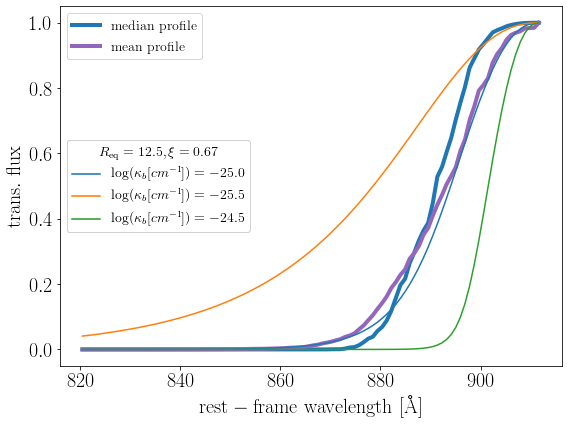

In [10]:
fig=plt.figure(figsize=(8,6)) 
axes = fig.subplots()

line1,=plt.plot(wv_rest_arr,median_p,label=r"$\rm median \ profile$",lw=4,color="tab:blue")

line2,=plt.plot(wv_rest_arr,mean_p,label=r"$\rm mean \ profile$",lw=4,color="tab:purple")
legend1 = plt.legend(handles=[line1, line2], loc='upper left')


Req=12.5 #pMpc
xi=0.67
kapbg=10**(-25.) #cm^-2 wrong, cm^-1

tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

line3,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\log(\kappa_b[cm^{{-1}}])={:4.1f}$".format(np.log10(kapbg)))


Req=12.5 #pMpc
xi=0.67
kapbg=10**(-25.5) #cm^-2 wrong, cm^-1

tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

line4,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\log(\kappa_b[cm^{{-1}}])={:4.1f}$".format(np.log10(kapbg)))



Req=12.5 #pMpc
xi=0.67
kapbg=10**(-24.5) #cm^-2 wrong, cm^-1

tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

line5,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\log(\kappa_b[cm^{{-1}}])={:4.1f}$".format(np.log10(kapbg)))
legend2 = plt.legend(handles=[line3, line4,line5], loc='center left')
legend2.set_title(r"$R_{{\rm eq}}={:3.1f},\xi={:4.2f}$".format(Req,xi))
axes.add_artist(legend1)
axes.add_artist(legend2)

plt.xlabel(r"$\rm rest-frame \  wavelength \ [\r{A}]$")
plt.ylabel(r"$\rm trans. \ flux$")
plt.tight_layout()

plt.savefig("sim_beckermodel.pdf")

In [41]:
dir(legend2)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_agg_filter',
 '_alpha',
 '_animated',
 '_approx_text_height',
 '_auto_legend_data',
 '_axes',
 '_bbox_to_anchor',
 '_clipon',
 '_clippath',
 '_contains',
 '_custom_handler_map',
 '_default_contains',
 '_default_handler_map',
 '_draggable',
 '_drawFrame',
 '_find_best_position',
 '_findoffset',
 '_fontsize',
 '_get_anchored_bbox',
 '_get_clipping_extent_bbox',
 '_get_loc',
 '_gid',
 '_in_layout',
 '_init_legend_box',
 '_label',
 '_legend_box',
 '_legend_handle_box',
 '_legend_title_box',
 '_loc',
 '_loc_real',
 '_loc_used_default',
 '_mode',
 '_mouseover',
 '_ncol',
 '_oid',
 '_path_effects',
 '_picker',